## We need to discover 2 folders - ecg and founded_data
- *unn_ecg* folder contains a bunch of .edf-.json pairs, where .edf file contains ECG and related medical data and .json contains description and diagnosis 
- *icebeb_ecg* folder contains three subfolders with .mat files which contains ECG data + REFERENCE.csv file with diagnosis labels

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tqdm

## First we need to sanitize our data and then convert it to one format.

# ICBEB part

In [2]:
! ls icbeb_ecg/

ls: cannot access 'icbeb_ecg/': No such file or directory


In [3]:
icbeb_dir_list = ["./icbeb_ecg/TrainingSet1/", "./icbeb_ecg/TrainingSet2/", "./icbeb_ecg/TrainingSet3/"]

In [4]:
icbeb_diagnosis_df = pd.read_csv("./icbeb_ecg/REFERENCE.csv")
icbeb_diagnosis_df.head()

,Recording,First_label,Second_label,Third_label
0,A0001,5,NaN,NaN
1,A0002,1,NaN,NaN
2,A0003,2,NaN,NaN
3,A0004,2,NaN,NaN
4,A0005,7,NaN,NaN


In [5]:
preliminary_df = icbeb_diagnosis_df[['Recording']].join(pd.get_dummies(icbeb_diagnosis_df.First_label))

In [6]:
for col_name in pd.get_dummies(icbeb_diagnosis_df.Second_label).columns:
    preliminary_df[col_name] = preliminary_df[col_name] + pd.get_dummies(icbeb_diagnosis_df.Second_label)[col_name]

In [7]:
for col_name in pd.get_dummies(icbeb_diagnosis_df.Third_label).columns:
    preliminary_df[col_name] = preliminary_df[col_name] + pd.get_dummies(icbeb_diagnosis_df.Third_label)[col_name]

In [8]:
icbeb_diagnosis_df = preliminary_df.set_index('Recording')

In [9]:
icbeb_to_normal_diagnosis_mapping = {
    1: "Normal",
    2: "AF",
    3: "I-AVB",
    4: "LBBB",
    5: "RBBB",
    6: "PAC",
    7: "PVC",
    8: "STD",
    9: "STE",
}

In [32]:
icbeb_diagnosis_df = icbeb_diagnosis_df.rename(icbeb_to_normal_diagnosis_mapping,axis=1)

Text(0, 0.5, 'diagnosis')

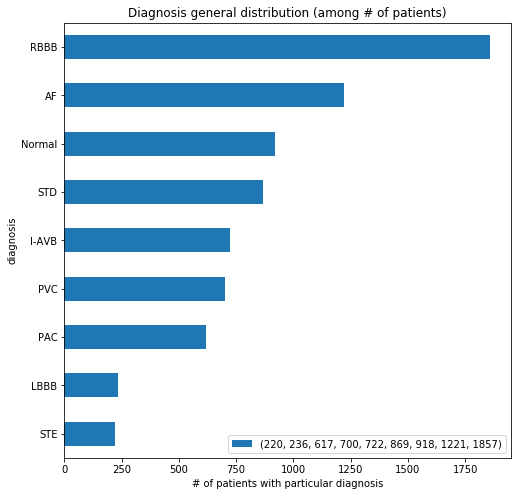

In [33]:
plt.figure(figsize=(8, 8))
icbeb_diagnosis_df.sum(axis=0).sort_values().plot.barh(
    label=tuple(icbeb_diagnosis_df.sum(axis=0).sort_values().values.tolist()),
)
# plt.text(x = r4[i]-0.5 , y = bars4[i]+0.1, s = label[i], size = 6)
plt.legend()
plt.title("Diagnosis general distribution (among # of patients)")
plt.xlabel("# of patients with particular diagnosis")
plt.ylabel("diagnosis")

In [34]:
icbeb_diagnosis_df.head()

,Normal,AF,I-AVB,LBBB,RBBB,PAC,PVC,STD,STE
Recording,,,,,,,,,
A0001,0,0,0,0,1,0,0,0,0
A0002,1,0,0,0,0,0,0,0,0
A0003,0,1,0,0,0,0,0,0,0
A0004,0,1,0,0,0,0,0,0,0
A0005,0,0,0,0,0,0,1,0,0


In [14]:
icbeb_ecg_data_dict = dict()
for folder in icbeb_dir_list:
    for elem in tqdm.tqdm(os.listdir(folder)):
        if elem.endswith(".mat"):
            icbeb_ecg_data_dict[elem.replace(".mat", "")] = loadmat(os.path.join(folder, elem))['ECG'][0][0][-1]

100%|██████████| 2408/2408 [00:17<00:00, 136.58it/s]


# UNN part

In [15]:
unn_ecg_path = "./unn_ecg"

In [16]:
patient_keys_with_pairs = set([it.replace(".json", "") 
                for it in os.listdir(unn_ecg_path) if it.endswith('.json')]) & set([it.replace(".edf", "") 
                for it in os.listdir(unn_ecg_path) if it.endswith('.edf')])

In [17]:
patient_data_paths_dict = dict()
for key in patient_keys_with_pairs:
    patient_data_paths_dict[key] = dict()
    patient_data_paths_dict[key]['json_path'] = os.path.join(unn_ecg_path, key + ".json")
    patient_data_paths_dict[key]['edf_path'] = os.path.join(unn_ecg_path, key + ".edf")

In [18]:
def parse_unn_diagnosis_df(data_paths_dict: dict):
    _diagnosis_df = pd.DataFrame()
    for patient in data_paths_dict:
        df_ = pd.DataFrame(
            pd.read_json(open(data_paths_dict[patient]['json_path']), orient='columns', typ='series', dtype=False)
        ).T
        df_['patient'] = patient
        _diagnosis_df = _diagnosis_df.append(df_.set_index('patient'))
    return _diagnosis_df.applymap(lambda x: int(x))

In [19]:
# %%time
patient_diagnosis_df = parse_unn_diagnosis_df(patient_data_paths_dict)
patient_diagnosis_df.head()

,left_ventricular_hypertrophy,sinus_tachycardia,normal,nodal_rhythm,AV_blockade_III_st,atrial_rhythm,abnormalities_Q_right ventricle,AV_dissociation,impaired_T_wave_lead_i,CA_blockade,...,nodal,WPW_syndrome,sharp_right_deviation,MI_with_ST_lift_rear_wall,incomplete_left_bundle_branch_blockade,extended_QT_interval,impaired_T_wave_lead_ii,horizontal,elongated_PQ,atrial_flutter
patient,,,,,,,,,,,,,,,,,,,,,
1102555300,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1102625369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
60910312,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50623136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50665873,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'diagnosis')

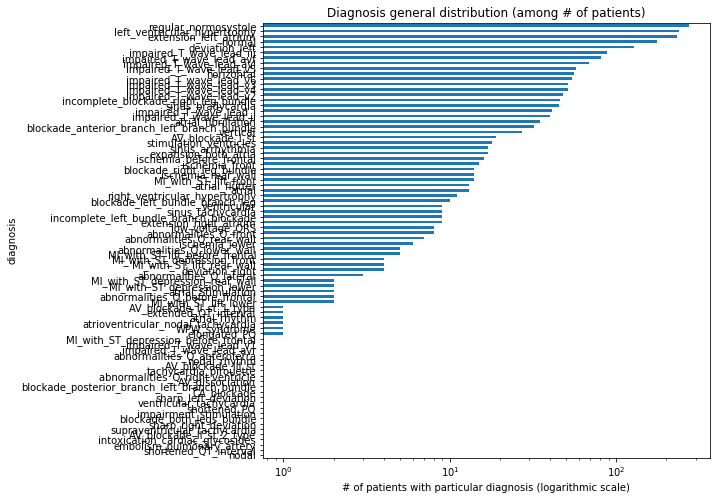

In [20]:
plt.figure(figsize=(8, 8))
patient_diagnosis_df.sum(axis=0).sort_values().plot.barh()
plt.title("Diagnosis general distribution (among # of patients)")
plt.xlabel("# of patients with particular diagnosis (logarithmic scale)")
plt.xscale('log')
plt.ylabel("diagnosis")

In [43]:
unn_diagnosis_to_normal_mapping = {
    'normal': "Normal",
    'atrial_fibrillation': "AF",
    'AV_blockade_I_st': "I-AVB",
    'blockade_left_bundle_branch_leg': "LBBB", # maybe incomplete_left_bundle_branch_blockade suits too?
    'blockade_right_leg_bundle': "RBBB", # maybe incomplete_blockade_right_leg_bundle suits too?
#     6: "PAC", # none of used in unn's jsons diagnosis suitable for this case 
#     7: "PVC", # none of used in unn's jsons diagnosis suitable for this case 
#     8: "STD", # will be merged manually
#     9: "STE", # will be merged manually
}

In [45]:
std_label_list = ['MI_with_ST_depression_front',
                 'MI_with_ST_depression_lower',
                 'MI_with_ST_depression_rear_wall']
ste_label_list = ['MI_with_ST_lift_before_frontal',
                     'MI_with_ST_lift_front',
                     'MI_with_ST_lift_lower',
                     'MI_with_ST_lift_rear_wall']

In [50]:
patient_diagnosis_df['STD'] = patient_diagnosis_df[std_label_list].sum(axis=1)
patient_diagnosis_df['STE'] = patient_diagnosis_df[ste_label_list].sum(axis=1)

In [51]:
needed_list = list(unn_diagnosis_to_normal_mapping.keys()) + ['STD', 'STE']

In [56]:
patient_diagnosis_df = patient_diagnosis_df[needed_list].rename(unn_diagnosis_to_normal_mapping, axis=1)

In [65]:
patient_diagnosis_df = patient_diagnosis_df[patient_diagnosis_df.sum(axis=1)!=0]

Text(0, 0.5, 'diagnosis')

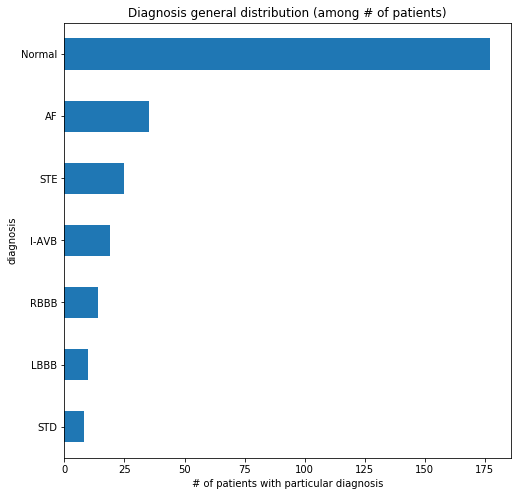

In [66]:
plt.figure(figsize=(8, 8))
patient_diagnosis_df.sum(axis=0).sort_values().plot.barh()
plt.title("Diagnosis general distribution (among # of patients)")
plt.xlabel("# of patients with particular diagnosis")
plt.ylabel("diagnosis")

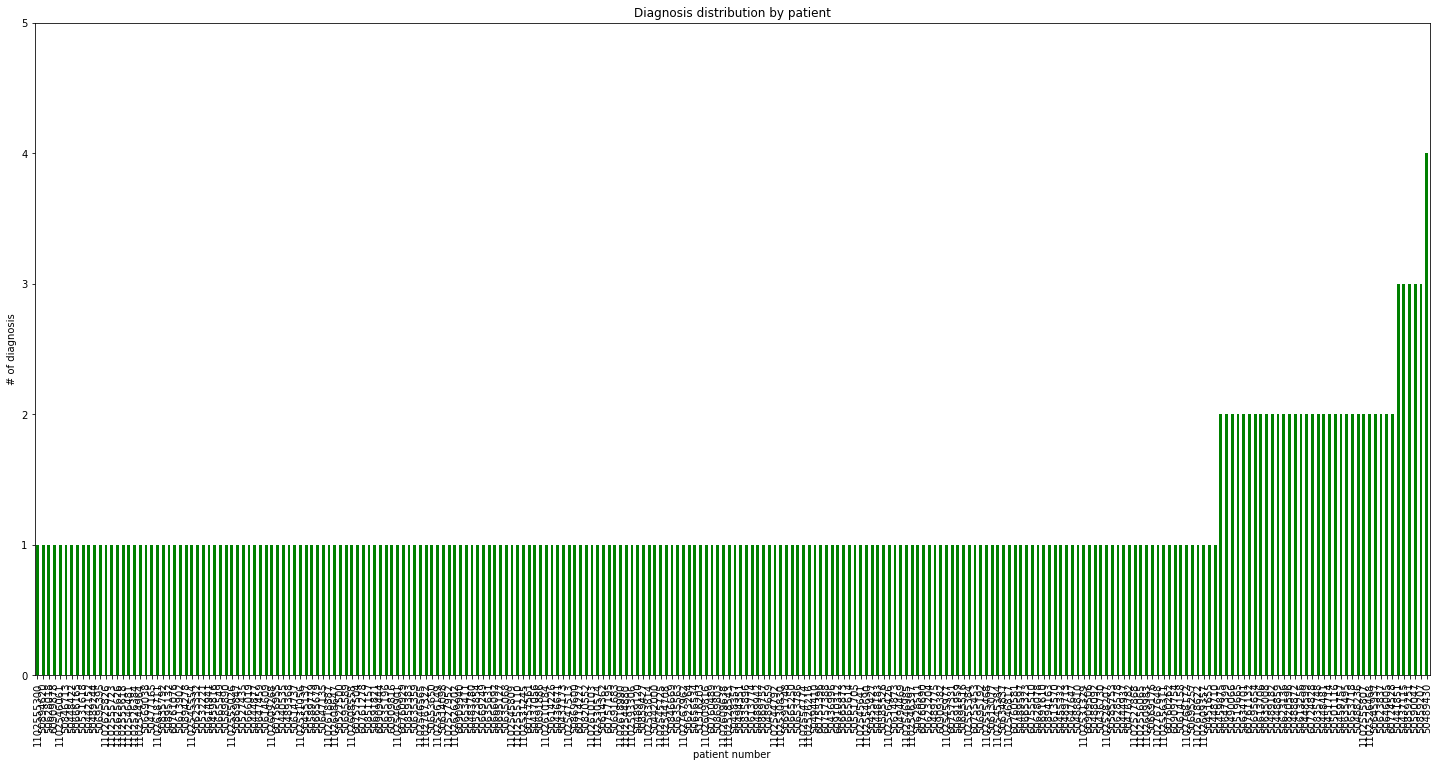

In [67]:
plt.figure(figsize=(25, 12))
patient_diagnosis_df.sum(axis=1).sort_values().plot.bar(color='g')
plt.title("Diagnosis distribution by patient")
plt.xlabel("patient number")
plt.yticks(np.arange(0, 6, step=1))
plt.ylabel("# of diagnosis")
pass

In [24]:
import pyedflib

In [25]:
patient_ecg_data_dict = dict()
for patient in patient_diagnosis_df.index:
    try:
        with pyedflib.EdfReader(os.path.join(unn_ecg_path, patient + ".edf")) as ecg_x:
            sigbufs = np.zeros((ecg_x.signals_in_file, ecg_x.getNSamples()[0]))
            for i in np.arange(ecg_x.signals_in_file):
                sigbufs[i, :] = ecg_x.readSignal(i)
                patient_ecg_data_dict[patient] = sigbufs
            ecg_x._close()
    except:
        print(patient)

1003297330


In [26]:
patient_ecg_data_dict['50647519'].shape

(12, 5000)